In [1]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import itertools
%matplotlib inline

### Tree-Based Nonparametric Priors

##### Mondrian Processes

A *Mondrian Process* is a prior over kd-trees.  

In [2]:
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

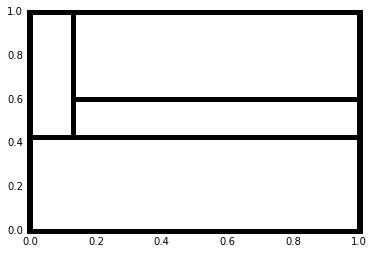

In [13]:
Z = np.array([[0.,1.],[0.,1.]])
parts = draw_Mondrian(Z, 1.)

plt.figure()

def print_partitions(p):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], '-k', linewidth=5)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], '-k', linewidth=5)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], '-k', linewidth=5)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], '-k', linewidth=5)
    
    else:
        print_partitions(p[1])
        print_partitions(p[2])

print_partitions(parts)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

Obs. number of partitions: 3.98
Number of obs. predicted by theory: 4.00

Obs. partition size: 0.36
Part. size pred. by theory: 0.33



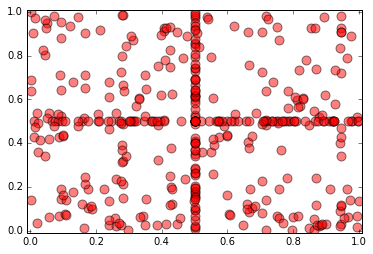

In [16]:
def get_medians(p):
    if not p[1] and not p[2]: 
        median = [(p[0][0,0]+p[0][0,1])/2., (p[0][1,0]+p[0][1,1])/2.]
        return [median]
    else:
        return get_medians(p[1]) + get_medians(p[2])
    
def get_partition_sizes(p):
    if not p[1] and not p[2]: 
        return [(p[0][0,1]-p[0][0,0])*(p[0][1,1]-p[0][1,0])]
    else:
        return get_partition_sizes(p[1]) + get_partition_sizes(p[2])
    

N = 100
lambda_0 = 1.

n_partitions = 0.
medians = []
avg_partition_size = 0.
for n in xrange(N):
    parts = draw_Mondrian(Z, lambda_0)
    m = get_medians(parts)
    s = get_partition_sizes(parts)
    n_partitions += len(m)
    medians += m
    avg_partition_size += np.mean(s)
medians = np.array(medians)

mc_expected_n_parts = n_partitions / N
theory_n_parts = (1+lambda_0)**Z.shape[0]
print "Obs. number of partitions: %.2f" %(mc_expected_n_parts)
print "Number of obs. predicted by theory: %.2f" %(theory_n_parts)
print

mc_part_size = avg_partition_size / N
theory_part_size = ((Z[0,1]-Z[0,0])*(Z[1,1]-Z[1,0]))/(theory_n_parts-1)
print "Obs. partition size: %.2f" %(mc_part_size)
print "Part. size pred. by theory: %.2f" %(theory_part_size)
print

plt.figure()

plt.scatter(medians[:,0], medians[:,1], c='r', edgecolors='k', s=80, alpha=.5)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

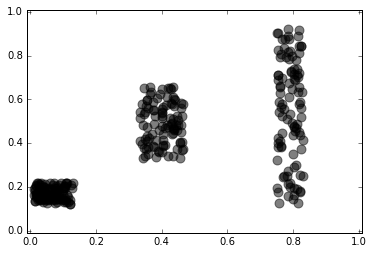

In [17]:
# Generate some data
data = []
N = 100
true_boxes = [np.array([[.75,.83],[.12,.92]]), np.array([[.01,.13],[.12,.22]]), np.array([[.33,.47],[.33,.66]])]
for box in true_boxes:
    for n in xrange(N):
        data.append([np.random.uniform(low=box[0,0], high=box[0,1]), np.random.uniform(low=box[1,0], high=box[1,1])])
data = np.array(data)

plt.figure()
plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=80, alpha=.5)

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

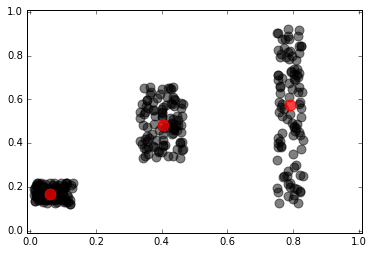

In [57]:
K = 1
lambda_k = .75
N = data.shape[0]
medians = [np.array([np.random.uniform(low=0,high=1), np.random.uniform(low=0,high=1)]) for k in xrange(K)]
change = True
assignments = [-1] * N
iteration = 0

while change and iteration < 1000:
    change = False
    iteration += 1
    
    # assign points to partition
    for d_idx in xrange(N):
        min_d = 1000.
        assign_idx = -1
        
        for k_idx, median in enumerate(medians):
            l1_dist = np.sum(np.abs(data[d_idx]-median))
            if l1_dist <= min_d: 
                assign_idx = k_idx
                min_d = l1_dist
                
        if min_d > 1./(2*lambda_k):
            medians.append(0.+data[d_idx])
            assignments[d_idx] = len(medians)
        else:
            if assignments[d_idx] != assign_idx: change = True
            assignments[d_idx] = assign_idx
            
    # calculate new medians
    for k_idx in xrange(len(medians)):
        assigned_x = []
        for d_idx in xrange(N):
            if assignments[d_idx] == k_idx:
                assigned_x.append(data[d_idx,:])
                
        if len(assigned_x) > 0:
            medians[k_idx] = np.median(np.array(assigned_x), axis=0)
        else: 
            medians[k_idx] = np.array([-10,-10])
            
final_medians = np.array(medians)

plt.figure()
plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=80, alpha=.5)
plt.scatter(final_medians[:,0], final_medians[:,1], c='r', edgecolors='r', s=120, alpha=.75)

'''
for median in medians:
    if median[0] < 0: continue
    p = np.array([[median[0] - 1./(4*lambda_k), median[0] + 1./(4*lambda_k)],[median[1] - 1./(4*lambda_k), median[1] + 1./(4*lambda_k)]])
    plt.plot([p[0,0], p[0,0]], [p[1,0], p[1,1]], '-k', linewidth=5)
    plt.plot([p[0,1], p[0,1]], [p[1,0], p[1,1]], '-k', linewidth=5)
    plt.plot([p[0,0], p[0,1]], [p[1,0], p[1,0]], '-k', linewidth=5)
    plt.plot([p[0,0], p[0,1]], [p[1,1], p[1,1]], '-k', linewidth=5)
'''

plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

##### Dirichlet Diffusion Trees

A *Dirichlet Diffusion Tree* is a prior over branching Gaussian diffusion processes.  

In [45]:
def divergence_fn(t):
    return .2 * t

def draw_DDT(budget=1.):
    t = 0.
    x = [[[0.], [0.]]]
    while t < budget:
        for x_path in x:
            x_path[0].append(t)
            x_path[1].append( x_path[1][-1] + np.random.normal(scale=1*.0001) )
            
            if np.random.uniform() < divergence_fn(t):
                x.append([[t],[x_path[1][-1]]])
                
        t += .05
    return x

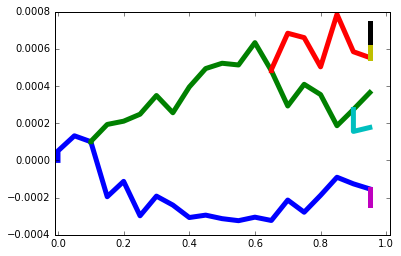

In [52]:
time_budget = 1.
paths = draw_DDT(time_budget)

plt.figure()

for p in paths:
    plt.plot(p[0], p[1], linewidth=5)

plt.xlim(-0.01, time_budget+.01)
plt.show()